# Purpose

This code is aimed to train `a ANN model` to predict the `distribution of accumulated plastic strain` in the cross-section of solder joint.

The dataset include `351 training dataset`, `39 test dataset`, and `36 validation dataset`

`Folder structure`:

```text

├── traindata_npy/
│   ├── inputs.npy
│   ├── outputs.npy
│   └── co_ind.npy
├── testdata_npy/
│   ├── inputs.npy
│   └── outputs.npy
└── valdata_npy/
    ├── inputs.npy
    └── outputs.npy


```

`Dataset features`:

| Input features         | output features    |                             coordinate values| 
|----------------------|------------------------------------------ |------------------------------------------ |
| `Temperature(℃)`     |   `Accumulated equivalent plastic strain(mm/mm)` for 48 elements | `x, z` coordinates of 48 elements | 
| `Amplitude(mm)`       |                          |  | 
| `Young's Modulus(GPa)`  |                       |  | 


## Required Libraries




In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd



## Create ANN Model

`NN structure`: 3 → 64 → 128 → 64 → 48

``` python

if self.af_output_flag == 1:
            x = F.softplus(self.fc4(x))
        else:   
            x = self.fc4(x)

```
The above code is for the output layer activation function. If the activation function is `softplus`, then the output layer is initialized with `F.softplus(self.fc4(x))`. So the output will not be negative any more. Otherwise, the output layer is initialized with `self.fc4(x)`, it's possible that the output will be negative.

In [ ]:

class Net(nn.Module):
    def __init__(self, af_output_flag = 1):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 48)
        self.af_output_flag = af_output_flag

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        if self.af_output_flag == 1:
            x = F.softplus(self.fc4(x))
        else:   
            x = self.fc4(x)
        return x
    
if __name__ == '__main__':
    test_net = Net()
    print(test_net)

Net(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=48, bias=True)
)


## Dataset Preparation

dataformat: tensor

training data: `features`, `labels`

validation data: `features_val`, `labels_val`

test data: `test_x_n`, `test_y_n`

input features scaled to [-1,1]: There are some negative values in the input factor Temperature.

output labels scaled to [0,1]


In [ ]:

filepath_in = r'C:\Users\Admin\Desktop\WHK CS NN code\traindata_npy\inputs_48.npy'
filepath_out = r'C:\Users\Admin\Desktop\WHK CS NN code\traindata_npy\outputs_48.npy'

filepath_val_in = r'C:\Users\Admin\Desktop\WHK CS NN code\valdata_npy\inputs_48.npy'
filepath_val_out = r'C:\Users\Admin\Desktop\WHK CS NN code\valdata_npy\outputs_48.npy'

test_filepath_in = r'C:\Users\Admin\Desktop\WHK CS NN code\testdata_npy\inputs_48.npy'
test_filepath_out = r'C:\Users\Admin\Desktop\WHK CS NN code\testdata_npy\outputs_48.npy'

pos_filepath = r'C:\Users\Admin\Desktop\WHK CS NN code\traindata_npy\coordinate_index_48.npy'


x = np.load(filepath_in).astype(np.float32)
y = np.load(filepath_out).astype(np.float32)

# ----------------------------- Scale the data 
scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

x = scaler_x.fit_transform(x).reshape(-1, 3)
y = scaler_y.fit_transform(y).reshape(-1, 48)

x_val = np.load(filepath_val_in).astype(np.float32)
y_val = np.load(filepath_val_out).astype(np.float32)

x_val = scaler_x.transform(x_val).reshape(-1, 3)
y_val = scaler_y.transform(y_val).reshape(-1, 48)

features = torch.tensor(x, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float).view(-1, 48)

features_val = torch.tensor(x_val, dtype=torch.float)
labels_val = torch.tensor(y_val, dtype=torch.float).view(-1, 48)

test_x = np.load(test_filepath_in)
test_y = np.load(test_filepath_out)

test_x = np.array(test_x, dtype=np.float32)
test_y = np.array(test_y, dtype=np.float32)

test_x_n = scaler_x.transform(test_x).reshape(-1, 3)

test_y_n = scaler_y.transform(test_y).reshape(-1, 48)

test_x_n = torch.tensor(test_x_n, dtype=torch.float).view(-1, 3)
test_y_n = torch.tensor(test_y_n, dtype=torch.float).view(-1, 48)

## Train the model

### Setting Hyperparameters

loss: `log_cosh_loss`

optimizer: `AdamW`

learning rate: `0.001`

beats: `(0.95, 0.999)` (First-order momentum of the control gradient, Second-order momentum of the control gradient)

weight_decay: `5e-6` Weight decay to prevent overfitting.

early stopping: `patience=15`



In [5]:
torch.manual_seed(0)
np.random.seed(0)

my_net = Net(af_output_flag=0) 
my_net.init_weights()

def log_cosh_loss(y_pred, y_true):
    return torch.mean(torch.log(torch.cosh(y_pred - y_true + 1e-12))) 
criterion = log_cosh_loss

# criterion = nn.MSELoss()

optimizer = optim.AdamW(my_net.parameters(), lr=0.001, betas=(0.95, 0.999), weight_decay=5e-6)


loss_values = []
val_loss_values = []
best_val_loss = float('inf')
patience = 15
patience_counter = 0  
early_stopping_triggered = False
negative_values_log = {}

### Training the model

max epoch = 10000


In [7]:
my_net.train()

for epoch in range(10000):
    my_net.train()
    optimizer.zero_grad()
    outputs_train = my_net(features)
    train_loss = criterion(outputs_train, labels)
    train_loss.backward()


    optimizer.step()

    #evalution
    my_net.eval()
    with torch.no_grad():
        outputs_val = my_net(features_val)
        val_loss = criterion(outputs_val, labels_val)


    negative_positions = torch.where(outputs_train < 0)
    num_negative_values = negative_positions[0].shape[0]
    negative_values_log[epoch + 1] = {
        "count": num_negative_values,
        "positions": negative_positions
    }

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0  
        torch.save(my_net.state_dict(), r'C:\Users\Admin\Desktop\WHK CS NN code\NN code\model_param\best_model_48_nw.pth')
    else:
        patience_counter += 1

    
    if (patience_counter >= patience) and (train_loss.item() < 8e-6):
        print(f'Early stopping triggered at epoch {epoch + 1}')
        print(f'Best Loss at epoch {epoch + 1 - patience}')
        print(f'Best Loss: {loss_values[-patience]}')
        early_stopping_triggered = True
        break

    loss_values.append(train_loss.item())
    val_loss_values.append(val_loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1} - Loss: {train_loss.item()}')

if not early_stopping_triggered:
    print('Training completed without early stopping')


Epoch 1 - Loss: 0.04630258306860924
Epoch 101 - Loss: 0.0008890662575140595
Epoch 201 - Loss: 0.00017890460730995983
Epoch 301 - Loss: 8.251565304817632e-05
Epoch 401 - Loss: 4.52743552159518e-05
Epoch 501 - Loss: 3.0248780603869818e-05
Epoch 601 - Loss: 2.3141361452871934e-05
Epoch 701 - Loss: 1.8894754248321988e-05
Epoch 801 - Loss: 1.55353936861502e-05
Epoch 901 - Loss: 1.3257955288281664e-05
Epoch 1001 - Loss: 1.1615604307735339e-05
Epoch 1101 - Loss: 1.0433489478600677e-05
Epoch 1201 - Loss: 9.495386620983481e-06
Epoch 1301 - Loss: 8.725589395908173e-06
Epoch 1401 - Loss: 7.899670890765265e-06
Epoch 1501 - Loss: 7.220014140330022e-06
Epoch 1601 - Loss: 6.465064871008508e-06
Epoch 1701 - Loss: 5.850049547007075e-06
Epoch 1801 - Loss: 5.398429493652657e-06
Epoch 1901 - Loss: 5.00704527439666e-06
Epoch 2001 - Loss: 4.630918738257606e-06
Epoch 2101 - Loss: 4.3210397961956915e-06
Epoch 2201 - Loss: 4.0550544326833915e-06
Epoch 2301 - Loss: 3.7815768791915616e-06
Epoch 2401 - Loss: 3.50

### visualization of the network performance

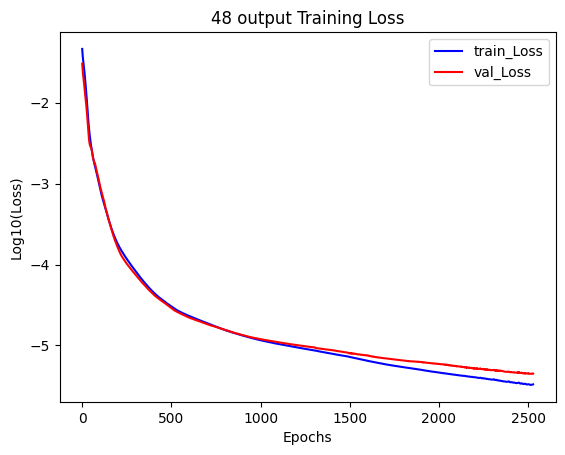

In [8]:
plt.plot(np.log10(loss_values), label='train_Loss', color='blue')
plt.plot(np.log10(val_loss_values), label='val_Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Log10(Loss)')
plt.title('48 output Training Loss')
plt.legend()
plt.show()

## Predicting performance of the model on the test set

```python
    test_outputs = my_net(test_x_n)
    test_outputs_zero = torch.clamp(test_outputs, min=0)
```
`test_outputs`: original output of the model on the test set

`test_outputs_zero`: output of the model on the test set with all negative values clamped to 0



In [18]:
my_net.load_state_dict(torch.load(r'C:\Users\Admin\Desktop\WHK CS NN code\NN code\model_param\best_model_48_nw.pth', weights_only=True))

my_net.eval()

with torch.no_grad():
    test_outputs = my_net(test_x_n)
    test_outputs_zero = torch.clamp(test_outputs, min=0)

    test_loss = criterion(test_outputs, test_y_n)
    test_loss_zero = criterion(test_outputs_zero, test_y_n)

test_outputs = scaler_y.inverse_transform(test_outputs.numpy())

test_outputs = np.clip(test_outputs, 0, None)

print(f'Test Loss: {test_loss.item():.16f}')
print(f'Test Loss processed: {test_loss_zero.item():.16f}')

Test Loss: 0.0000037873342080
Test Loss processed: 0.0000037745344343


### Visualizing the Test Set Predictions

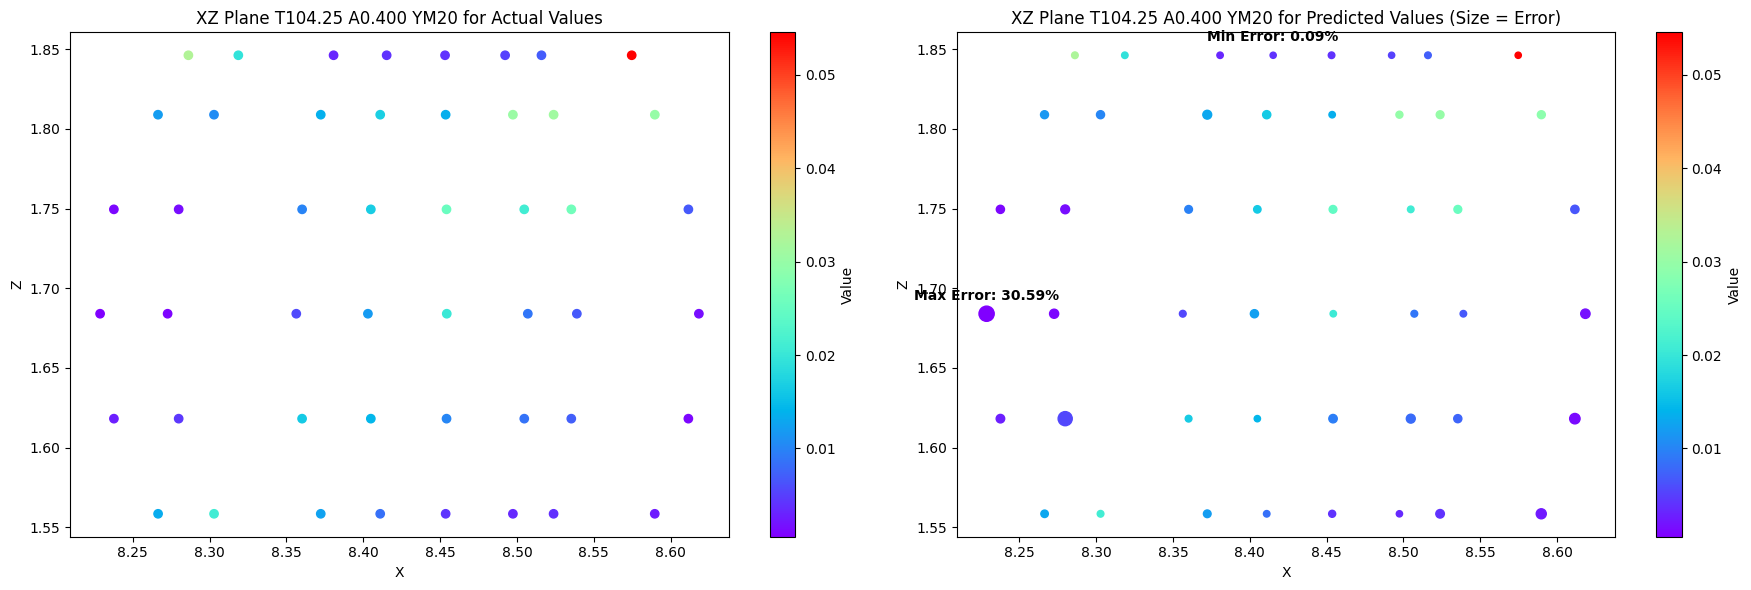

In [22]:

pos = np.load(pos_filepath)
df_pos = pd.DataFrame(pos)
df_actual = pd.DataFrame(test_y.T)
df_predict = pd.DataFrame(test_outputs.T)
ind = df_pos.sort_values(by=[1, 0], ascending=[False, True]).index

i = 11 # max value < len(test_x) 39

T, A, YM = test_x[i]
# actual_filename = f'T{T:.2f} A{A:.3f} YM{int(YM)} actual values.xlsx'
# predicted_filename = f'T{T:.2f} A{A:.3f} YM{int(YM)} predicted values.xlsx'
# percentage_error_filename = f'T{T:.2f} A{A:.3f} YM{int(YM)} percentage error.xlsx'
fig_title_actual = f'XZ Plane T{T:.2f} A{A:.3f} YM{int(YM)} for Actual Values'
fig_title_predicted = f'XZ Plane T{T:.2f} A{A:.3f} YM{int(YM)} for Predicted Values (Size = Error)'
# save_plot_title = f'XZ_Plane_T{T:.2f}_A{A:.3f}_YM{int(YM)}_for_Comparison.png'



test_i_actual = df_actual[i].iloc[ind].values
matrix_1 = test_i_actual.reshape(6,8)


test_i_pre = df_predict[i].iloc[ind].values
matrix_2 = test_i_pre.reshape(6,8)

df_matrix_1 = pd.DataFrame(matrix_1)
df_matrix_2 = pd.DataFrame(matrix_2)

percentage_error = np.abs(matrix_2 - matrix_1) / np.abs(matrix_1) * 100

df_percentage_error = pd.DataFrame(percentage_error)

x = df_pos[0].iloc[ind].values
z = df_pos[1].iloc[ind].values
values_actual = pd.DataFrame(test_i_actual)
values_predict = pd.DataFrame(test_i_pre)
error_values = percentage_error.reshape(-1,1)
error_scaled = (error_values - error_values.min()) / (error_values.max() - error_values.min()) * 100


vmin = min(values_actual.values.min(), values_predict.values.min())
vmax = max(values_actual.values.max(), values_predict.values.max())

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sc = plt.scatter(x, z, c=values_actual, cmap='rainbow', vmin=vmin, vmax=vmax)
color_bar = plt.colorbar(sc)
color_bar.set_label('Value')  
plt.title(fig_title_actual)
plt.xlabel('X')
plt.ylabel('Z')

max_error_idx = np.argmax(error_scaled)
min_error_idx = np.argmin(error_scaled)

# Get the x and z coordinates for these max and min error points
max_error_x = x[max_error_idx]
max_error_z = z[max_error_idx]
min_error_x = x[min_error_idx]
min_error_z = z[min_error_idx]

# Get the actual error values at these points
max_error_value = error_values[max_error_idx].item()
min_error_value = error_values[min_error_idx].item()

plt.subplot(1, 2, 2)
sc = plt.scatter(x, z, c=values_predict, cmap='rainbow', s=error_scaled+20, alpha=1, vmin=vmin, vmax=vmax)
color_bar = plt.colorbar(sc)
color_bar.set_label('Value')  
plt.title(fig_title_predicted)
plt.xlabel('X')
plt.ylabel('Z')

plt.annotate(f'Max Error: {max_error_value:.2f}%', 
        (max_error_x, max_error_z), 
        textcoords="offset points", 
        xytext=(0, 10), 
        ha='center', 
        fontsize=10, 
        color='black', 
        weight='bold')

plt.annotate(f'Min Error: {min_error_value:.2f}%', 
        (min_error_x, min_error_z), 
        textcoords="offset points", 
        xytext=(0, 10), 
        ha='center', 
        fontsize=10, 
        color='black', 
        weight='bold')



plt.tight_layout()
plt.show()